![Quantum Random Walks](/images/SymmetricQRW.png)

# Quantum Random Walks

Here we demonstrate some simple code to explore quantum random walks.

<!-- TEASER_END -->

In [1]:
import mmf_setup; mmf_setup.nbinit()

<IPython.core.display.Javascript object>

# Single Particle in a Box

We start with a model of a single particle in a periodic box (Section III.A from [Kempe:2003]).  Equation numbers correspond to [Kempe:2003.]  The wavefunction is then simply a vector on our set of $N$ abscissa.  This wavefunction lives in our original Hilbert space $\mathcal{H}_P$ spanned by the basis of "position" eigenstates $\ket{n}$ such that $\abs{\braket{\psi|n}}^2$ is the probability that the particle is on the $n$th run of the ladder.
$
  \newcommand{\ua}{\uparrow}
  \newcommand{\da}{\downarrow}
$
The full quantum random walk problem lives in an axuilliary Hilbert space $\mathcal{H} = \mathcal{H}_C\otimes \mathcal{H}_P$ where $\mathcal{H}_C$ is a two-dimensional Hilbert space spanned by two spin states $\ket{\ua}$, $\ket{\da}$.  The idea here is that motion up the ladder corresponds with being in the spin state $\ket{\ua}$ while motion down the ladder corresponds to $\ket{\da}$.  The unitary evolution operator is thus:

\begin{gather}
  \mat{S} = \ket{\ua}\bra{\ua}\otimes \sum_{n}\ket{n+1}\bra{n} + \ket{\da}\bra{\da}\otimes \sum_{n}\ket{n-1}\bra{n}.
  \tag{12}
\end{gather}

In [2]:
%pylab inline
from collections import namedtuple

def tprod(A, B):
    """Return the tensor product of A and B."""
    dim = len(A.shape)
    if dim == 1:
        AB = np.einsum('a,i->ai', A, B)
    elif len(A.shape) == 2:
        AB = np.einsum('ab,ij->aibj', A, B)
    else:
        raise NotImplementedError
    return AB.reshape(np.prod(AB.shape[:dim]),
                      np.prod(AB.shape[dim:]))

# Raise a matrix to a power
mpow = np.linalg.matrix_power

def apply(A, psi):
    """Return `A(psi)`, applying the operator A to psi."""
    return A.dot(psi.ravel()).reshape(psi.shape)

def get_U(N=256):
    """Return the unitary evolution operators for an N site lattice."""
    x = np.arange(N) - N//2
    n = np.eye(N)             # Position basis vectors
    n_plus_1 = np.hstack([n[:, 1:], n[:, :1]])
    n_minus_1 = np.hstack([n[:, -1:], n[:, :-1]])

    ua, da = s = np.eye(2)    # Spin basis vectors

    S = (tprod(ua[:, None]*ua[None, :], n_plus_1.dot(n.T)) + 
         tprod(da[:, None]*da[None, :], n_minus_1.dot(n.T)))

    # Hadamard coin (13)
    C = np.array([[1, 1], 
                  [1, -1]])/np.sqrt(2)

    # Unbiased coin (17)
    Y = np.array([[1, 1j], 
                  [1j, 1]])/np.sqrt(2)
    U_C = S.dot(tprod(C, np.eye(N)))
    U_Y = S.dot(tprod(Y, np.eye(N)))
    assert np.allclose(np.eye(2*N), S.dot(S.T.conj()))
    assert np.allclose(np.eye(2*N), U_C.dot(U_C.T.conj()))
    assert np.allclose(np.eye(2*N), U_Y.dot(U_Y.T.conj()))
    Results = namedtuple('Results', ['N', 'x', 'U_C', 'U_Y'])
    return Results(N=N, x=x, U_C=U_C, U_Y=U_Y)

Populating the interactive namespace from numpy and matplotlib


Now we start from the state $\ket{\da}\otimes\ket{0}$ and evolve with the unitary evolution operator:

$$
  \mat{U} = \mat{S}\cdot(\mat{C}\otimes\mat{1}).
$$

Doing this 100 times, we obtain Fig. 5 from [Kempe:2003].

Text(0.5,1,'Fig. 5 from [Kempte:2003]')

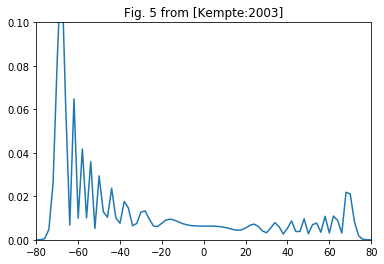

In [3]:
res = get_U(N=200)
psi = np.zeros((2, res.N))
psi[1, res.N//2] = 1

psi_100 = apply(mpow(res.U_C, 100), psi)

# Plot only even indices as the odd sites are not occupied
# Note: this depends on the value of N chosen.
plt.plot(res.x[0::2], (abs(psi_100)**2).sum(axis=0)[0::2])
plt.axis([-80, 80, 0, 0.1])
plt.title("Fig. 5 from [Kempte:2003]")

Starting from a symmetric initial condition we obtain Fig. 6.  (It appears they forgot to normalize the initial state properly.)

Text(0.5,1,'Fig. 5 from [Kempte:2003]')

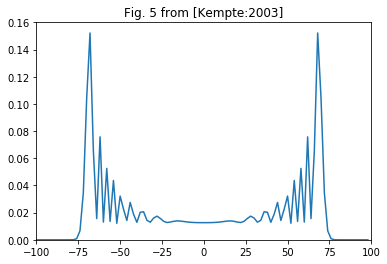

In [4]:
psi = np.zeros((2, res.N), dtype=complex)
psi[0, res.N//2] = 1 #/np.sqrt(2)  # Kempte: seems to miss this normalization
psi[1, res.N//2] = 1j #/np.sqrt(2)

psi = apply(mpow(res.U_C, 100), psi)

# Plot only odd indices as the even sites are not occupied.
plt.plot(res.x[0::2], (abs(psi)**2).sum(axis=0)[0::2])
plt.axis([-100, 100, 0, 0.16])
plt.title("Fig. 5 from [Kempte:2003]")

*MMF Note: Using the coin $Y$ from (17) does not seem to give symmetric evolution like they claim... not sure why.*

[-80, 80, 0, 0.1]

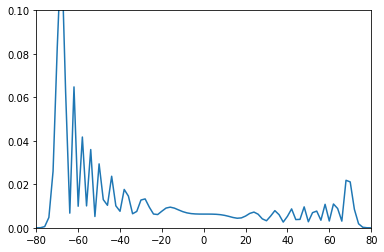

In [5]:
psi = np.zeros((2, res.N), dtype=complex)
psi[1, res.N//2] = 1.0

psi_100 = apply(mpow(res.U_Y, 100), psi)

# Plot only odd indices as the even sites are not occupied
plt.plot(res.x[0::2], (abs(psi_100)**2).sum(axis=0)[0::2])
plt.axis([-80, 80, 0, 0.1])

Let's look at the evolution now, anticipating a comparison with [Dadras:2018].

Text(0.5,1,'Fig. 1 from [Dadras:2018]')

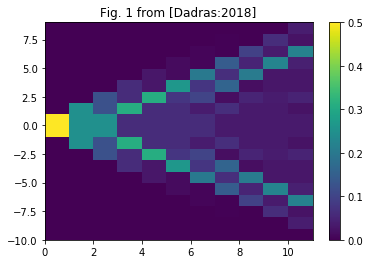

In [6]:
res = get_U(N=20)
psi = np.zeros((2, res.N), dtype=complex)
psi[0, res.N//2] = 1/np.sqrt(2)
psi[1, res.N//2-1] = 1/np.sqrt(2)

psis = [psi]
Ts = np.arange(12)
for T in Ts[1:]:
    psis.append(apply(res.U_C, psis[-1]))

psis = np.asarray(psis)
ns = (abs(psis)**2).sum(axis=1)
plt.pcolormesh(Ts, res.x, ns.T)
plt.colorbar()
plt.title("Fig. 1 from [Dadras:2018]")
plt.savefig("images/SymmetricQRW.png")

One can get a biased quantum walk by starting from a different initial state, or by using a different coin.  In [Dadras:2018] they use a different coin.  Try to reproduce their Fig. 2.

Text(0.5,1,'Not quite Fig. 2 from [Dadras:2018]')

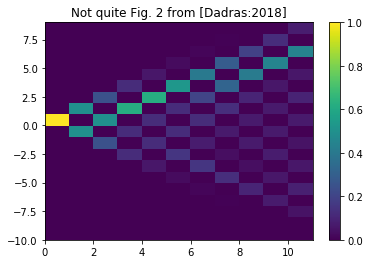

In [7]:
res = get_U(N=20)
psi = np.zeros((2, res.N), dtype=complex)
psi[0, res.N//2] = 1
psi[1, res.N//2-1] = 0

psis = [psi]
Ts = np.arange(12)
for T in Ts[1:]:
    psis.append(apply(res.U_C, psis[-1]))

psis = np.asarray(psis)
ns = (abs(psis)**2).sum(axis=1)
plt.pcolormesh(Ts, res.x, ns.T)
plt.colorbar()
plt.title("Not quite Fig. 2 from [Dadras:2018]")

# References

* [**[Kempe:2008]**: Quantum random walks - an introductory overview](https://arxiv.org/abs/quant-ph/0303081)
* [**[Dadras:2018]**: Realization of a quantum walk in momentum space with a Bose-Einstein condensate](https://arXiv.org/abs/1802.08160)